# ottimizzazione dei parametri della strategia

utilizzando [optuna](https://optuna.org/) è possibile effettuare una ricerca dei parametri della strategia che danno un migliore risultato basandosi sulla "massimizzazione" dei valore riportato da un `analyzer` di `backtrader`.

Gli `analyzer` supportati nella classe base `OptunaOptimizeStrategy` sono:

* sqn
* vwr
* sharpe_ratio

Se non specificato verranno scelti i parametri che ottengono il massimo PNL cumulativo

In [1]:
from strategies_tester.strategies import OptunaOptimizeStrategy,CrossStrategy
import optuna


class OptimizeCrossStrategy(OptunaOptimizeStrategy):
    # l'attributo strategy deve essere un riferimento alla classe della strategia ad ottimizzare
    strategy = CrossStrategy

    # override di questa funzione permette di definire i parametri ottimizzare
    def get_parameters(self, trial: optuna.Trial):
        kwargs = {
            "ma_fast_type": trial.suggest_categorical('ma_fast_type', ['ema', 'sma']),
            "ma_fast_period": trial.suggest_categorical('ma_fast_period', [5, 9, 10, 13, 21, 34, 55, 89, 144]),

            "ma_slow_type": trial.suggest_categorical('ma_slow_type', ['ema', 'sma']),
            "ma_slow_period": trial.suggest_categorical('ma_slow_period', [21, 34, 55, 89, 144, 200, 233, 377, 610]),

            "stop_loss": trial.suggest_int("stop_loss", 1, 200),

            "use_mfi": trial.suggest_categorical('use_mfi', [True, False])
        }

        # è possibile definire dipendenze e altre logiche per la generazioni dei valori dei parametri
        if kwargs['use_mfi']:
            kwargs['mfi_high'] = trial.suggest_int("mfi_high", 1, 100)
            kwargs['mfi_low'] = trial.suggest_int("mfi_low", 1, 100)

        return kwargs

In [2]:
from datetime import datetime

from strategies_tester.datafetcher import DataFetcher
from strategies_tester.strategies import *
from strategies_tester.utils_backtest import backtest_strategy

from dotenv import load_dotenv, find_dotenv

In [3]:
load_dotenv(find_dotenv())

OPTUNA_STORAGE=os.getenv("OPTUNA_STORAGE", "sqlite:///data/optuna.db")

time_periods = [
    (datetime(year=2017, month=1, day=1), datetime(year=2020, month=1, day=1)),
]
analyzer = "sharpe_ratio"
tf = "1h"
start_cash = 1000
symbol = "XBTUSD"
exchange = "bitmex"
max_evals = 100
perc_size = 100
commission = 0.00075
# n_jobs: numero di trial eseguti in contemporanea.
#         se si usa sqlite come storage potrebbe creare problemi eseguire più di trial in contemporanea
n_jobs = 1
study_name = f"cross-{symbol}-{analyzer}-{tf}"

In [4]:
opt = OptimizeCrossStrategy(
    study_name=study_name,
    exchange=exchange,
    symbol=symbol,
    bin_size=tf,
    analyzer=analyzer,
    perc_size=perc_size,
    commission=commission,
    start_cash=start_cash,
    optuna_storage=OPTUNA_STORAGE,
    time_periods=time_periods
)

100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


In [5]:
best = opt.run(
    max_evals=max_evals,
    n_jobs=n_jobs
)

print(f"parametri ottenuti dall'ottimizzazione: {best}")

[I 2020-05-18 20:57:33,676] Using an existing study with name 'cross-XBTUSD-sharpe_ratio-1h' instead of creating a new one.


parametri ottenuti dall'ottimizzazione: {'ma_fast_period': 10, 'ma_fast_type': 'sma', 'ma_slow_period': 610, 'ma_slow_type': 'sma', 'mfi_high': 36, 'mfi_low': 30, 'stop_loss': 47, 'use_mfi': True}


In [6]:
f = time_periods[-1][0]
t = time_periods[-1][1]
dfetch = DataFetcher()
df = dfetch.download_data(exchange='bitmex', symbol='XBTUSD', bin_size='1h', date_from=f, date_to=t)

start_cash = 1000
cerebro, thestrats = backtest_strategy(
    df=df,
    strategy=opt.strategy,
    start_cash=start_cash,
    commission=commission,
    perc_size=perc_size,
    verbose=True,

    **best
)



final value: 1002.9410590256248


<IPython.core.display.Javascript object>


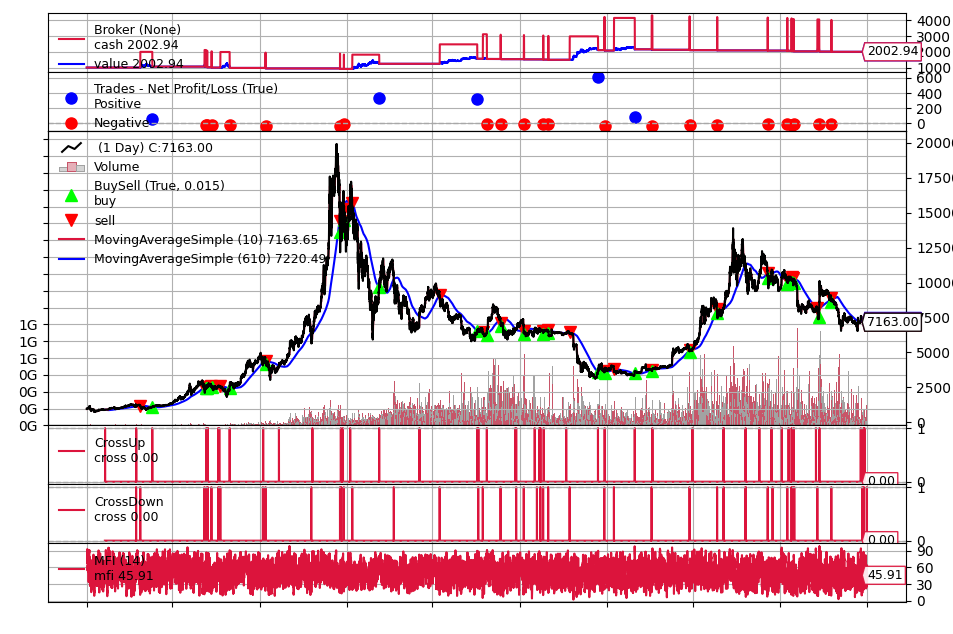

[[<Figure size 640x480 with 7 Axes>]]

In [7]:
portvalue = cerebro.broker.getvalue()
print(f"final value: {portvalue - start_cash}")
cerebro.plot()